In [2]:
import numpy as np 
import pandas as pd


In [3]:

import os
base_folder_path = "/kaggle/input/eye-diseases-classification/dataset"
folders = os.listdir(base_folder_path)
images_paths = []
labels = []
for fold in folders:
    folder_path = os.path.join(base_folder_path, fold)
    file_paths = os.listdir(folder_path)
    for path in file_paths:
        image_path = os.path.join(folder_path, path)
        images_paths.append(image_path)
        labels.append(fold)
df = pd.DataFrame(data = {"Image Path":images_paths,"Label":labels})
df.head()

,Image Path,Label
0,/kaggle/input/eye-diseases-classification/data...,glaucoma
1,/kaggle/input/eye-diseases-classification/data...,glaucoma
2,/kaggle/input/eye-diseases-classification/data...,glaucoma
3,/kaggle/input/eye-diseases-classification/data...,glaucoma
4,/kaggle/input/eye-diseases-classification/data...,glaucoma


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Path  4217 non-null   object
 1   Label       4217 non-null   object
dtypes: object(2)
memory usage: 66.0+ KB


# Data split

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [6]:
train_df , test_df = train_test_split(df,test_size=0.2,random_state=42,stratify=df["Label"])
test_df,valid_df = train_test_split(test_df,test_size=0.5,random_state=42,stratify=test_df["Label"])

In [7]:
print("Train Shape : ",train_df.shape)
print("Test Shape : ",test_df.shape)
print("Validation Shape ",valid_df.shape)

Train Shape :  (3373, 2)
Test Shape :  (422, 2)
Validation Shape  (422, 2)


In [8]:
print("Train Classes : ",train_df.Label.value_counts())
print("Test Classes : ",test_df.Label.value_counts())
print("Validation Classes",valid_df.Label.value_counts())

Train Classes :  Label
diabetic_retinopathy    878
normal                  859
cataract                830
glaucoma                806
Name: count, dtype: int64
Test Classes :  Label
diabetic_retinopathy    110
normal                  108
cataract                104
glaucoma                100
Name: count, dtype: int64
Validation Classes Label
diabetic_retinopathy    110
normal                  107
cataract                104
glaucoma                101
Name: count, dtype: int64


# Data Augmentation

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import matplotlib.pyplot as plt

In [10]:
datagen_train = ImageDataGenerator(
    rotation_range=10,        
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    shear_range=0.0,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest',
    rescale=1./255 
)

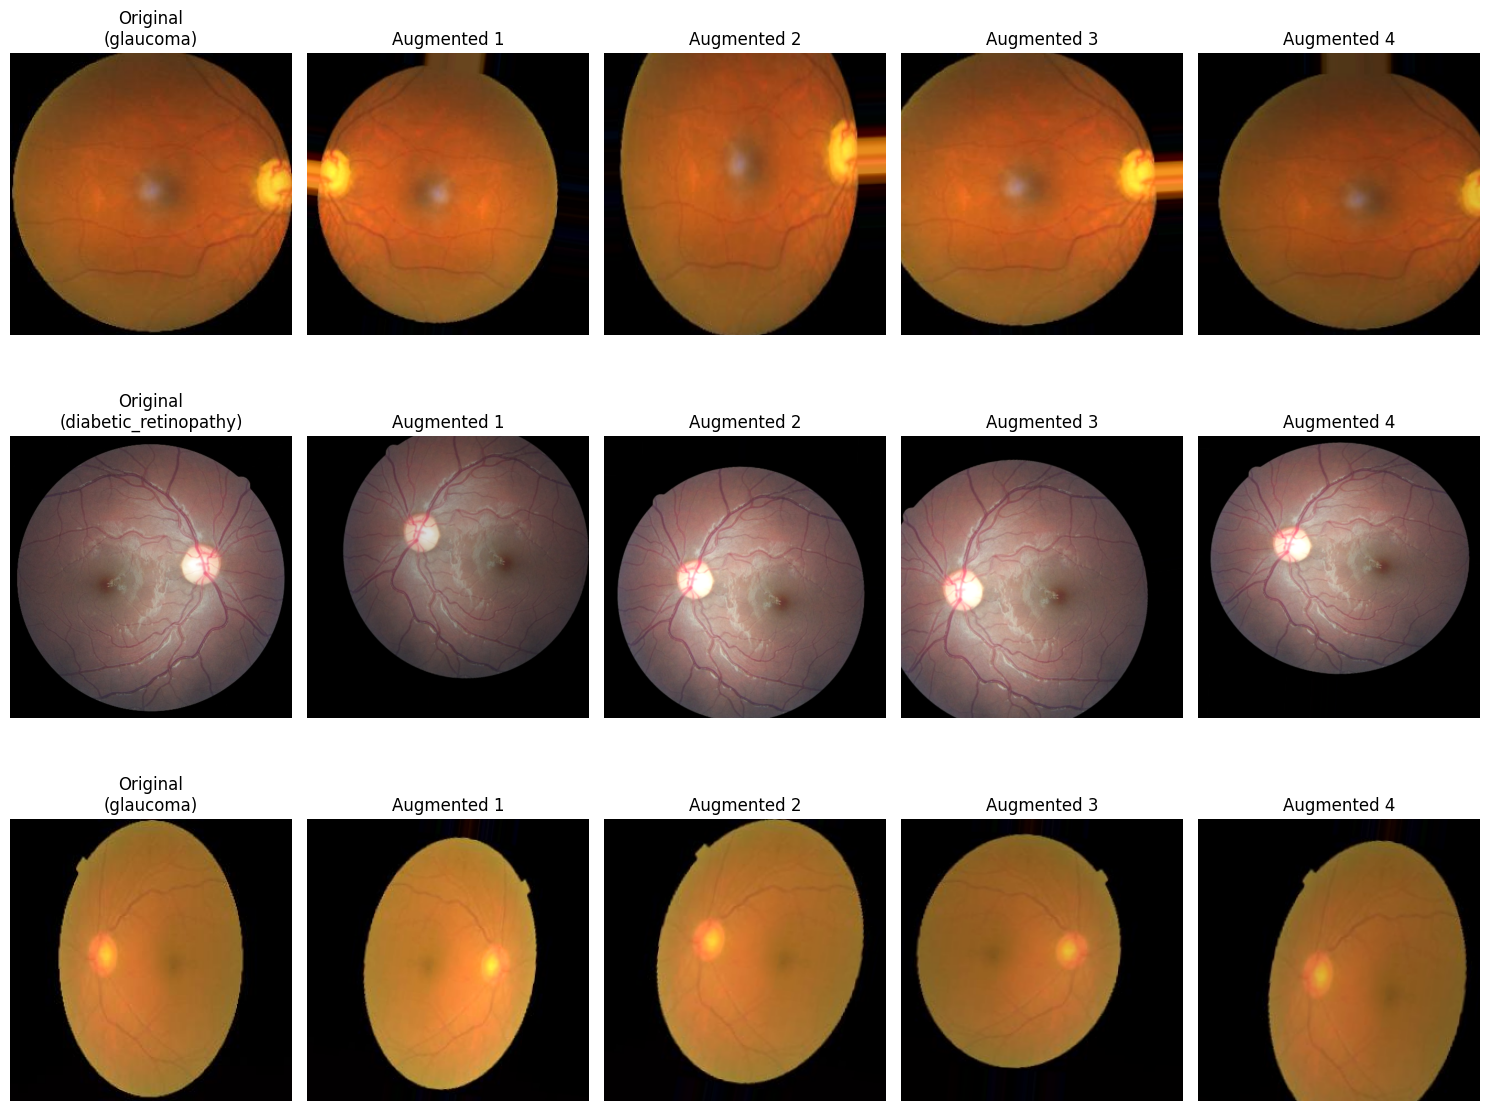

In [11]:
sample_paths = train_df['Image Path'].sample(3).tolist()
n_samples = len(sample_paths)
n_augmentations = 4  

plt.figure(figsize=(15, 4 * n_samples))

for i, img_path in enumerate(sample_paths):
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 
    plt.subplot(n_samples, n_augmentations + 1, i * (n_augmentations + 1) + 1)
    plt.imshow(img)
    plt.title(f"Original\n({train_df[train_df['Image Path'] == img_path]['Label'].iloc[0]})")
    plt.axis('off')

    # --- Plot Augmented Images ---
    i_aug = 0
    for batch in datagen_train.flow(x, batch_size=1):
        augmented_img = (batch[0] * 255).astype('uint8') 
        
        plt.subplot(n_samples, n_augmentations + 1, i * (n_augmentations + 1) + 2 + i_aug)
        plt.imshow(augmented_img)
        plt.title(f"Augmented {i_aug + 1}")
        plt.axis('off')
        
        i_aug += 1
        if i_aug >= n_augmentations:
            break 

plt.tight_layout()
plt.show()


# Build CNN

In [12]:
import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense ,BatchNormalization ,GlobalAveragePooling2D,Dropout,Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau